Shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies   

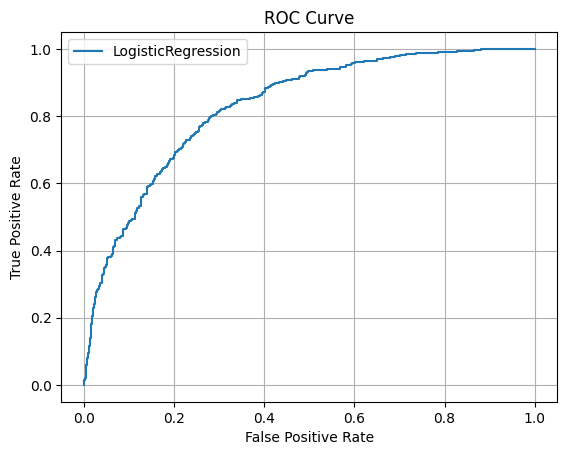

Model: RandomForestClassifier
Confusion Matrix:
 [[932 101]
 [191 183]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.64      0.49      0.56       374

    accuracy                           0.79      1407
   macro avg       0.74      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

ROC-AUC Score: 0.813416610153698


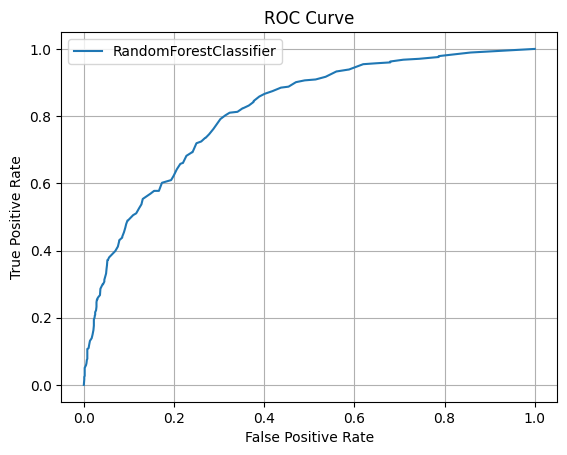

Model: XGBClassifier
Confusion Matrix:
 [[893 140]
 [192 182]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1033
           1       0.57      0.49      0.52       374

    accuracy                           0.76      1407
   macro avg       0.69      0.68      0.68      1407
weighted avg       0.75      0.76      0.76      1407

ROC-AUC Score: 0.8075668708035886


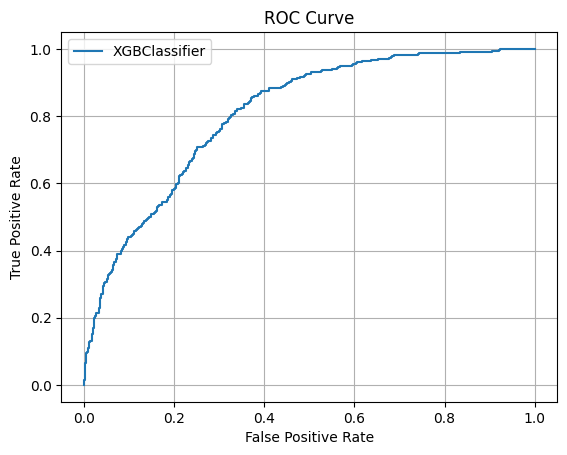

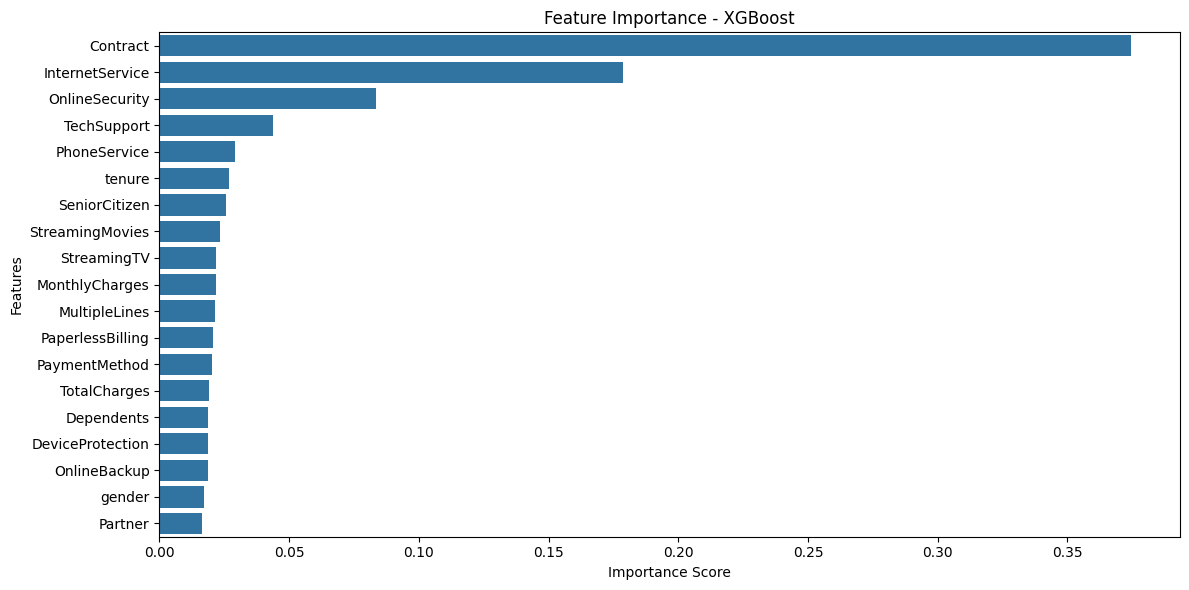

In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# Step 2: Load Dataset
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Shape:", df.shape)
print(df.head())

# Step 3: Data Cleaning
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)
df.drop('customerID', axis=1, inplace=True)
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Step 4: Encode Categorical Variables
cat_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Step 5: Train-Test Split
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Train Models
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Step 7: Evaluation Function
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"Model: {model.__class__.__name__}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{model.__class__.__name__}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

# Step 8: Evaluate All Models
evaluate_model(lr, X_test, y_test)
evaluate_model(rf, X_test, y_test)
evaluate_model(xgb, X_test, y_test)

# Step 9: Feature Importance (XGBoost)
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

# Step 10: Export Prediction Results
df_results = X_test.copy()
df_results['Actual Churn'] = y_test.values
df_results['Predicted Churn Probability'] = xgb.predict_proba(X_test)[:, 1]


In [19]:
# Reload original dataset to map encoded values
df_original = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df_original['TotalCharges'] = pd.to_numeric(df_original['TotalCharges'], errors='coerce')
df_original.dropna(subset=['TotalCharges'], inplace=True)
df_original.drop('customerID', axis=1, inplace=True)

# Merge predictions back with original labels
X_test_indexed = X_test.copy()
X_test_indexed['Predicted Churn Probability'] = xgb.predict_proba(X_test)[:, 1]
X_test_indexed['Actual Churn'] = y_test.values

# Reset index to join properly
df_original.reset_index(drop=True, inplace=True)
X_test_indexed.reset_index(drop=True, inplace=True)

# Merge using index for original values
merged_output = pd.concat([df_original.loc[X_test_indexed.index], X_test_indexed[['Predicted Churn Probability', 'Actual Churn']]], axis=1)

# Replace 1/0 with Yes/No for easier Power BI visuals
cols_to_convert = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

for col in cols_to_convert:
    merged_output[col] = merged_output[col].apply(lambda x: 'Yes' if x == 1 else 'No')


In [26]:
# Step 1: Load and clean original dataset
df_original = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df_original['TotalCharges'] = pd.to_numeric(df_original['TotalCharges'], errors='coerce')
df_original.dropna(subset=['TotalCharges'], inplace=True)
df_original.reset_index(drop=True, inplace=True)  # Important for alignment

# Step 2: Prepare the modeling dataframe
df_model = df_original.copy()
df_model['Churn'] = df_model['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Encode categorical columns for modeling
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df_model.select_dtypes(include='object').columns:
    if col != 'customerID':
        df_model[col] = le.fit_transform(df_model[col])

# Step 3: Train-test split (same as model)
from sklearn.model_selection import train_test_split
X = df_model.drop(['customerID', 'Churn'], axis=1)
y = df_model['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Predict churn probabilities using your trained XGBoost model
y_pred_prob = xgb.predict_proba(X_test)[:, 1]
y_test_reset = y_test.reset_index(drop=True)

# Step 5: Extract corresponding original rows (with human-readable values)
original_test_rows = df_original.loc[X_test.index].reset_index(drop=True)

# Step 6: Combine predictions with readable data
final_output = original_test_rows.copy()
final_output['Predicted Churn Probability'] = y_pred_prob
final_output['Actual Churn'] = y_test_reset.apply(lambda x: 'Yes' if x == 1 else 'No')

# Step 7: Save final file
final_output.to_csv("churn_predictions.csv", index=False)
print("✅ Saved: churn_predictions_readable_with_customerID.csv")


✅ Saved: churn_predictions_readable_with_customerID.csv


In [27]:
df = pd.read_csv("/content/churn_predictions.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Predicted Churn Probability,Actual Churn
0,6614-YWYSC,Male,1,Yes,No,61,Yes,Yes,No,No internet service,...,No internet service,No internet service,Two year,No,Bank transfer (automatic),25.00,1501.75,No,0.003090,No
1,9546-KDTRB,Female,0,No,No,19,Yes,Yes,No,No internet service,...,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),24.70,465.85,No,0.030289,No
2,0871-URUWO,Male,0,Yes,No,13,Yes,Yes,Fiber optic,No,...,Yes,Yes,Month-to-month,Yes,Credit card (automatic),102.25,1359.00,Yes,0.526708,Yes
3,5151-HQRDG,Male,0,Yes,No,37,Yes,Yes,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,55.05,2030.75,No,0.092502,No
4,6624-JDRDS,Female,0,No,No,6,No,No phone service,DSL,Yes,...,No,No,Month-to-month,No,Bank transfer (automatic),29.45,161.45,No,0.188470,No
